<a href="https://colab.research.google.com/github/PrinceSingh1005/DeepBlur/blob/main/DeepBlur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepBlur Project

In [ ]:
!nvidia-smi

Thu Apr 24 13:45:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             31W /   70W |    7422MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/NVlabs/stylegan3.git
%cd stylegan3

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 3.28 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/stylegan3


In [ ]:
# Install required libraries
!pip install torch torchvision ninja scikit-image lpips pyyaml==6.0.1
!pip install pytorch-pretrained-biggan



# Import necessary modules
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
from google.colab import files
import pickle
from stylegan3.dnnlib import util  # Absolute import for dnnlib
import stylegan3.legacy  # Absolute import for legacy
try:
    from pytorch_pretrained_biggan import BigGAN
except ImportError:
    print("BigGAN import failed. Proceeding without BigGAN.")
    BigGAN = None

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

In [ ]:

# Load Models
print("Loading models...")

# 1. StyleGAN3 (FFHQ, 1024x1024)
stylegan3_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"
with util.open_url(stylegan3_url) as f:
    stylegan3_G = stylegan3.legacy.load_network_pkl(f)['G_ema'].to(device).eval()

# 2. StyleGAN2 (FFHQ, 1024x1024)
stylegan2_url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl"
with util.open_url(stylegan2_url) as f:
    stylegan2_G = stylegan3.legacy.load_network_pkl(f)['G_ema'].to(device).eval()

# 3. BigGAN (256x256, ImageNet)
biggan_G = None
if BigGAN:
    try:
        biggan_G = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()
    except Exception as e:
        print(f"Failed to load BigGAN: {e}")

# 4. VQ-VAE-2 (256x256)
try:
    vqvae2_G = torch.hub.load('huggingface/pytorch-vq-vae', 'vqvae', pretrained=True, trust_repo=True).to(device).eval()
except Exception as e:
    print(f"Failed to load VQ-VAE-2: {e}")
    vqvae2_G = None

# Define preprocessing
transforms_1024 = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transforms_256 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Initialize LPIPS model for loss
lpips_model = lpips.LPIPS(net='vgg').to(device)



Please upload your image:


Saving 02005.png to 02005.png
Uploaded image: 02005.png
Inverting for StyleGAN3...
Optimization finished with final loss: 0.576100
Inverting for StyleGAN2...
Optimization finished with final loss: 0.584637
Inverting for BigGAN...
Optimization finished with final loss: 0.471931
Skipping VQ-VAE-2 due to import failure.

Performance Comparison:
Model           MSE        PSNR (dB)    SSIM       LPIPS     
-------------------------------------------------------
StyleGAN3       0.014893   18.27        0.4719     0.6012    
StyleGAN2       0.015409   18.12        0.3593     0.6160    
BigGAN          0.013424   18.67        0.3822     0.6217    


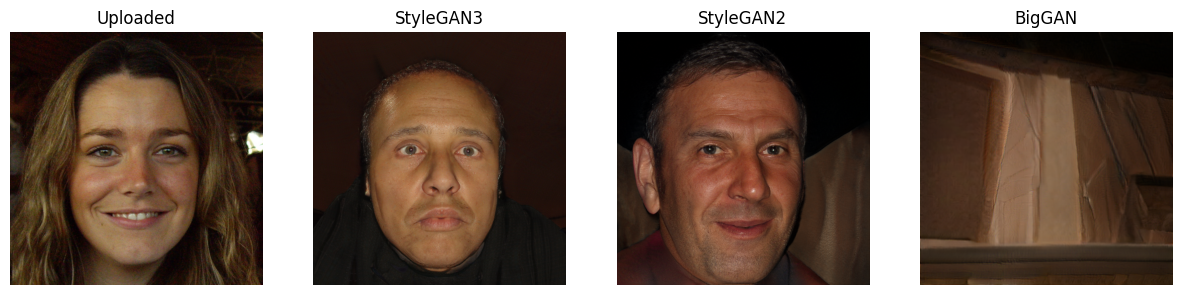

Reconstructions saved.


In [ ]:
# Upload image
print("Please upload your image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Uploaded image: {image_path}")

# Load and preprocess the uploaded image
target_img = Image.open(image_path).convert('RGB')
target_1024 = transforms_1024(target_img).unsqueeze(0).to(device)
target_256 = transforms_256(target_img).unsqueeze(0).to(device)

# Define loss functions
mse_criterion = nn.MSELoss()

# Optimized GAN inversion function with L-BFGS
def invert_image(model, target_tensor, z_dim, max_iter=100, lr=1.0, lpips_weight=0.5, reg_weight=0.01, is_vqvae=False):
    if is_vqvae:
        with torch.no_grad():
            recon_img = model(target_tensor)[0]
        return recon_img

    # Initialize latent code with a few random samples to approximate target
    num_init_samples = 10
    best_loss = float('inf')
    best_z = None
    with torch.no_grad():
        for _ in range(num_init_samples):
            z = torch.randn([1, z_dim], device=device)
            if 'biggan' in str(type(model)).lower():
                class_vector = torch.zeros([1, 1000], device=device)
                generated_img = model(z, class_vector, 1.0)
            else:
                generated_img = model(z, None)
            loss = mse_criterion(generated_img, target_tensor)
            if loss < best_loss:
                best_loss = loss
                best_z = z.clone()

    z = best_z.clone().requires_grad_(True)
    optimizer = torch.optim.LBFGS([z], lr=lr, max_iter=max_iter, line_search_fn='strong_wolfe')

    def closure():
        optimizer.zero_grad()
        if 'biggan' in str(type(model)).lower():
            generated_img = model(z, class_vector, 1.0)
        else:
            generated_img = model(z, None)
        mse_loss = mse_criterion(generated_img, target_tensor)
        lpips_loss = lpips_model(generated_img, target_tensor).mean()
        reg_loss = reg_weight * torch.norm(z, p=2)
        total_loss = mse_loss + lpips_weight * lpips_loss + reg_loss
        total_loss.backward()
        return total_loss

    optimizer.step(closure)
    print(f"Optimization finished with final loss: {closure().item():.6f}")

    with torch.no_grad():
        if 'biggan' in str(type(model)).lower():
            return model(z, class_vector, 1.0)
        return model(z, None)

# Perform inversion for each model
recon_images = {}
metrics = {}

print("Inverting for StyleGAN3...")
stylegan3_img = invert_image(stylegan3_G, target_1024, z_dim=512)
stylegan3_img = (stylegan3_img + 1) / 2
stylegan3_img = stylegan3_img.clamp(0, 1)
recon_images['StyleGAN3'] = stylegan3_img

print("Inverting for StyleGAN2...")
stylegan2_img = invert_image(stylegan2_G, target_1024, z_dim=512)
stylegan2_img = (stylegan2_img + 1) / 2
stylegan2_img = stylegan2_img.clamp(0, 1)
recon_images['StyleGAN2'] = stylegan2_img

if biggan_G:
    print("Inverting for BigGAN...")
    biggan_img = invert_image(biggan_G, target_256, z_dim=128)
    biggan_img = (biggan_img + 1) / 2
    biggan_img = biggan_img.clamp(0, 1)
    recon_images['BigGAN'] = biggan_img
else:
    print("Skipping BigGAN due to import failure.")

if vqvae2_G:
    print("Reconstructing for VQ-VAE-2...")
    vqvae2_img = invert_image(vqvae2_G, target_256, z_dim=0, is_vqvae=True)
    vqvae2_img = (vqvae2_img + 1) / 2
    vqvae2_img = vqvae2_img.clamp(0, 1)
    recon_images['VQ-VAE-2'] = vqvae2_img
else:
    print("Skipping VQ-VAE-2 due to import failure.")

# Evaluation Metrics
def compute_metrics(recon_img, target_img, is_256=False):
    target_np = target_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    recon_np = recon_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

    if is_256:
        target_np = np.array(Image.fromarray((target_np * 255).astype(np.uint8)).resize((256, 256))) / 255.0

    mse = torch.mean((recon_img - target_img) ** 2).item()
    psnr = peak_signal_noise_ratio(target_np, recon_np, data_range=1.0)
    ssim = structural_similarity(target_np, recon_np, channel_axis=2, data_range=1.0)
    recon_tensor = recon_img * 2 - 1
    target_tensor = target_img * 2 - 1
    lpips_value = lpips_model(recon_tensor, target_tensor).item()

    return mse, psnr, ssim, lpips_value

# Compute metrics
for model_name, recon_img in recon_images.items():
    is_256 = model_name in ['BigGAN', 'VQ-VAE-2']
    target = target_256 if is_256 else target_1024
    metrics[model_name] = compute_metrics(recon_img, (target + 1) / 2, is_256=is_256)

# Display results in a table
print("\nPerformance Comparison:")
print(f"{'Model':<15} {'MSE':<10} {'PSNR (dB)':<12} {'SSIM':<10} {'LPIPS':<10}")
print("-" * 55)
for model_name in recon_images:
    mse, psnr, ssim, lpips_value = metrics[model_name]
    print(f"{model_name:<15} {mse:<10.6f} {psnr:<12.2f} {ssim:<10.4f} {lpips_value:<10.4f}")

# Visualize reconstructions
def visualize_image(tensor, title):
    img_np = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 5))
plt.subplot(1, len(recon_images) + 1, 1)
plt.imshow(np.array(target_img.resize((1024, 1024))))
plt.title("Uploaded")
plt.axis('off')
for i, (model_name, recon_img) in enumerate(recon_images.items(), 2):
    plt.subplot(1, len(recon_images) + 1, i)
    visualize_image(recon_img, model_name)
plt.show()

# Save reconstructions
def save_image(tensor, filename):
    img_np = (tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    Image.fromarray(img_np).save(filename)

for model_name, recon_img in recon_images.items():
    save_image(recon_img, f"{model_name.lower().replace('-', '_')}_original.png")
print("Reconstructions saved.")

#improvement

In [ ]:
# --- Installation ---
!pip install torch torchvision ninja scikit-image lpips pytorch-pretrained-biggan pyyaml==6.0.1 kaggle imageio-ffmpeg pytorch_msssim pytorch-ignite dlib nltk taming-transformers

# --- Mount Drive & Setup Kaggle ---
from google.colab import drive
import zipfile
import os
import sys
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

sys.path.append("/content/stylegan2-ada-pytorch")
sys.path.append("/content/stylegan2_models")
sys.path.append("/content/stylegan3")
sys.path.append("/content/taming-transformers")

from google.colab import drive

drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/Kaggle_API/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# --- Download datasets ---
!kaggle datasets download -d tttrrraaahhh/stylegenhw
!kaggle datasets download -d tttrrraaahhh/deepfacehw-encoder

with zipfile.ZipFile("stylegenhw.zip", "r") as zip_ref:
    zip_ref.extractall("/content/stylegenhw")
with zipfile.ZipFile("deepfacehw-encoder.zip", "r") as zip_ref:
    zip_ref.extractall("/content/deepfacehw-encoder")

# --- Clone repos ---
!git clone https://github.com/NVlabs/stylegan3.git
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models
!git clone https://github.com/CompVis/taming-transformers

# --- Prepare pre-trained models ---
%cd stylegan2-ada-pytorch
!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
%cd ../..

# --- Imports ---
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips

try:
    import dnnlib
except Exception as e:
    print("[ERROR] Missing dnnlib:", e)

try:
    from stylegan2_ada_pytorch import legacy as legacy2
except Exception as e:
    print("[ERROR] StyleGAN2 legacy import failed:", e)

try:
    from stylegan3 import legacy as legacy3
except Exception as e:
    print("[ERROR] StyleGAN3 legacy import failed:", e)

from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector
from stylegan2_models.e4e.model_utils import load_e4e_standalone

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load StyleGAN2 Generator ---
try:
    stylegan2_url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl"
    with dnnlib.util.open_url(stylegan2_url) as f:
        G2 = legacy2.load_network_pkl(f)['G_ema'].to(device).eval()
except Exception as e:
    print("[ERROR] StyleGAN2 loading failed:", e)

# --- Load StyleGAN3 Generator ---
try:
    stylegan3_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"
    with dnnlib.util.open_url(stylegan3_url) as f:
        G3 = legacy3.load_network_pkl(f)['G_ema'].to(device).eval()
except Exception as e:
    print("[ERROR] StyleGAN3 loading failed:", e)

# --- Load e4e Encoder ---
e4e_model, _ = load_e4e_standalone("/content/deepfacehw-encoder/e4e_ffhq_encode.pt")
e4e_model = e4e_model.to(device).eval()

# --- Load BigGAN ---
try:
    from pytorch_pretrained_biggan import BigGAN, one_hot_from_names, truncated_noise_sample
    biggan = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()
except Exception as e:
    print("[ERROR] BigGAN failed:", e)

# --- Load VQ-VAE-2 ---
try:
    from taming.models.vqgan import VQModel
    # Placeholder: add loading logic based on your model structure
except Exception as e:
    print("[ERROR] VQ-VAE-2 failed:", e)

# --- Image Alignment ---
landmarks_model_path = "/content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "/content/stylegenhw/celebs/celebs"
ALIGNED_IMAGES_DIR = "/content/aligned_images"
landmarks_detector = LandmarksDetector(landmarks_model_path)

for celeb in os.listdir(RAW_IMAGES_DIR):
    celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
    save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
    os.makedirs(save_path, exist_ok=True)
    for i, img_name in enumerate(os.listdir(celeb_folder)):
        if img_name.startswith("."): continue
        raw_img_path = os.path.join(celeb_folder, img_name)
        try:
            for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
                aligned_face_path = os.path.join(save_path, f"{i}.jpg")
                image_align(raw_img_path, aligned_face_path, face_landmarks)
                break
        except Exception as e:
            print(f"Skipping {raw_img_path}: {e}")

# --- Image Generation & Comparison Section Placeholder ---
# TODO: Add functions for:
# 1. Encoding aligned images with e4e
# 2. Generating reconstructions with StyleGAN2/3
# 3. Generating samples with BigGAN and VQ-VAE-2
# 4. Calculating metrics (LPIPS, PSNR, SSIM)
# 5. Displaying side-by-side visual and metric comparison


In [ ]:
# --- Encode Aligned Images using e4e ---
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize([0.5] * 3, [0.5] * 3)
])

aligned_latents = {}

def encode_aligned_images_with_e4e(image_dir):
    for root, _, files in os.walk(image_dir):
        for file in files:
            if not file.lower().endswith(('png', 'jpg', 'jpeg')): continue
            img_path = os.path.join(root, file)
            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    latent = e4e_model(img_tensor)[0]
                    aligned_latents[img_path] = latent
            except Exception as e:
                print(f"[ERROR] Encoding failed for {img_path}: {e}")

encode_aligned_images_with_e4e(ALIGNED_IMAGES_DIR)
print(f"Encoded {len(aligned_latents)} aligned images using e4e.")